In [178]:
import pandas as pd
import numpy as np
import pyspark as ps
from matplotlib import pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error,mean_absolute_error
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [9]:
base_path = "/Users/gyanapradhan/Desktop/Datasets/blinkit/"
customer_feedback = pd.read_csv(base_path + "blinkit_customer_feedback.csv")
customers = pd.read_csv(base_path + "blinkit_customers.csv")
inventory = pd.read_csv(base_path + "blinkit_inventory.csv")
order_items = pd.read_csv(base_path + "blinkit_order_items.csv")
orders = pd.read_csv(base_path + "blinkit_orders.csv")

In [157]:
order_items.head(3)

,order_id,product_id,quantity,unit_price
0,1961864118,642612,3,517.03
1,1549769649,378676,1,881.42
2,9185164487,741341,2,923.84


In [38]:
sales_forecasting_2 = orders.copy(deep=False)
sales_forecasting_2.rename(columns={'order_total': 'total_sum'},inplace= True)

In [54]:
sales_forecasting_2= sales_forecasting_2.merge(customers[['customer_id','customer_segment','total_orders']], on='customer_id' ,how='left')


In [52]:
sales_forecasting_2= sales_forecasting_2.merge(customer_feedback[['customer_id','sentiment']], on='customer_id',how='left') 

In [55]:
sales_forecasting_2.head(2)

,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,total_sum,payment_method,delivery_partner_id,store_id,sentiment,customer_segment,total_orders
0,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Neutral,Regular,13
1,1961864118,30065862,2024-07-17 08:34:01,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Negative,Regular,13


In [60]:
sales_forecasting_2['order_date']=pd.to_datetime(sales_forecasting_2['order_date']).dt.date

In [65]:
inventory['date']=pd.to_datetime(inventory['date'],dayfirst=True).dt.date

In [66]:
inventory

,product_id,date,stock_received,damaged_stock
0,153019,2023-03-17,4,2
1,848226,2023-03-17,4,2
2,965755,2023-03-17,1,0
3,39154,2023-03-17,4,0
4,34186,2023-03-17,3,2
...,...,...,...,...
75167,298985,2024-11-05,3,0
75168,679284,2024-11-05,3,0
75169,240179,2024-11-05,3,0
75170,673058,2024-11-05,3,2


In [70]:

inventory_grouped=inventory.groupby('date',as_index=False)['stock_received'].sum()


In [90]:

sales_forecasting_2= sales_forecasting_2.merge(inventory_grouped,left_on='order_date' ,right_on='date', how='left')


In [155]:
stats =np.where(sales_forecasting_2['stock_received'].isna())

In [154]:
sales_forecasting_2['stock_received']=sales_forecasting_2['stock_received'].fillna(0)

In [156]:
stats

(array([], dtype=int64),)

In [160]:
order_items_grouped=order_items.groupby('order_id',as_index=False).agg({'quantity': 'sum','unit_price':'mean'})

In [161]:
 order_items_grouped

,order_id,quantity,unit_price
0,60465,2,826.21
1,2237858,1,799.46
2,3101265,1,44.35
3,5120698,1,53.49
4,5512907,3,319.34
...,...,...,...
4995,9993542681,1,951.43
4996,9996182478,3,280.35
4997,9997121955,2,994.56
4998,9997994965,2,310.69


In [166]:
sales_forecasting_2=sales_forecasting_2.merge(order_items_grouped, on='order_id',how='left')


In [170]:
sales_forecasting_2.head(2)

,order_id,customer_id,order_date,promised_delivery_time,actual_delivery_time,delivery_status,total_sum,payment_method,delivery_partner_id,store_id,sentiment,customer_segment,total_orders,date,stock_received,quantity,unit_price
0,1961864118,30065862,2024-07-17,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Neutral,Regular,13,2024-07-17,227.0,3,517.03
1,1961864118,30065862,2024-07-17,2024-07-17 08:52:01,2024-07-17 08:47:01,On Time,3197.07,Cash,63230,4771,Negative,Regular,13,2024-07-17,227.0,3,517.03


In [171]:
columnstodrop = ['order_id', 'customer_id', 'promised_delivery_time', 'actual_delivery_time','delivery_status', 'payment_method', 'delivery_partner_id', 'store_id',"date"]
# to Drop a row use "index="
#rowstodrop= ['row1','row2','row3','row4']
# df.drop(index= rowstodrop,inplace =True)
=sales_forecasting_2.drop(columns =columnstodrop, inplace=True)


In [173]:
sales_forecasting_2

,order_date,total_sum,sentiment,customer_segment,total_orders,stock_received,quantity,unit_price
0,2024-07-17,3197.07,Neutral,Regular,13,227.0,3,517.03
1,2024-07-17,3197.07,Negative,Regular,13,227.0,3,517.03
2,2024-07-17,3197.07,Negative,Regular,13,227.0,3,517.03
3,2024-05-28,976.55,Negative,New,5,231.0,1,881.42
4,2024-05-28,976.55,Negative,New,5,231.0,1,881.42
...,...,...,...,...,...,...,...,...
14881,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21
14882,2023-08-23,1879.46,Negative,Premium,6,293.0,1,826.21
14883,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21
14884,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21


In [191]:
sales_forecasting_2['order_date']= pd.to_datetime(sales_forecasting_2['order_date'])
sales_forecasting_2['order_month']= pd.to_datetime(sales_forecasting_2['order_date']).dt.month
sales_forecasting_2['order_day_of_week']= pd.to_datetime(sales_forecasting_2['order_date']).dt.dayofweek
sales_forecasting_2['order_day']= pd.to_datetime(sales_forecasting_2['order_date']).dt.day
# sales.forecasting_2.drop('order_date',inplace=True)'


In [192]:
sales_forecasting_2

,order_date,total_sum,sentiment,customer_segment,total_orders,stock_received,quantity,unit_price,order_month,order_day_of_week,order_day
0,2024-07-17,3197.07,Neutral,Regular,13,227.0,3,517.03,7,2,17
1,2024-07-17,3197.07,Negative,Regular,13,227.0,3,517.03,7,2,17
2,2024-07-17,3197.07,Negative,Regular,13,227.0,3,517.03,7,2,17
3,2024-05-28,976.55,Negative,New,5,231.0,1,881.42,5,1,28
4,2024-05-28,976.55,Negative,New,5,231.0,1,881.42,5,1,28
...,...,...,...,...,...,...,...,...,...,...,...
14881,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21,8,2,23
14882,2023-08-23,1879.46,Negative,Premium,6,293.0,1,826.21,8,2,23
14883,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21,8,2,23
14884,2023-08-23,1879.46,Positive,Premium,6,293.0,1,826.21,8,2,23


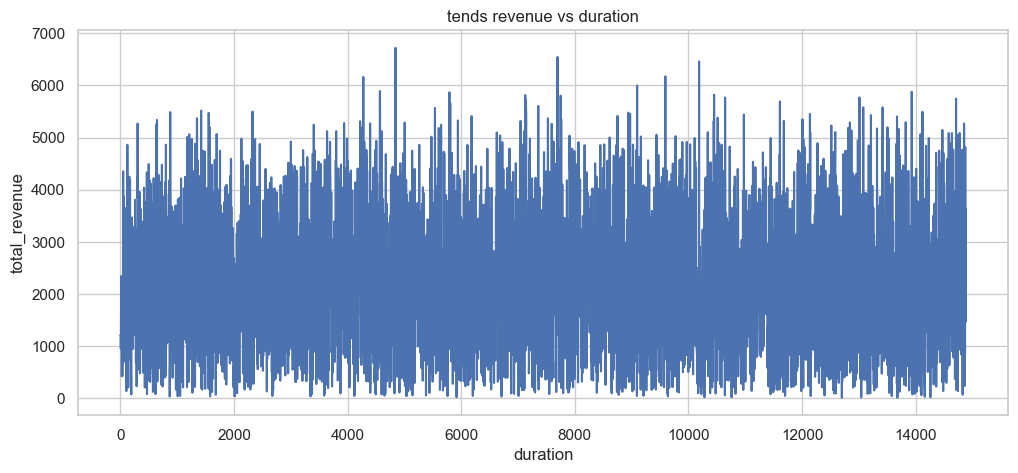

In [194]:
plt.figure(figsize=(12,5))
sns.lineplot(data=sales_forecasting_2.sort_values(by=["order_month","order_day"]),x=range(len(sales_forecasting_2)),y='total_sum')
plt.title('tends revenue vs duration')
plt.ylabel( 'total_revenue')
plt.xlabel('duration')
plt.tight_layout
plt.show()

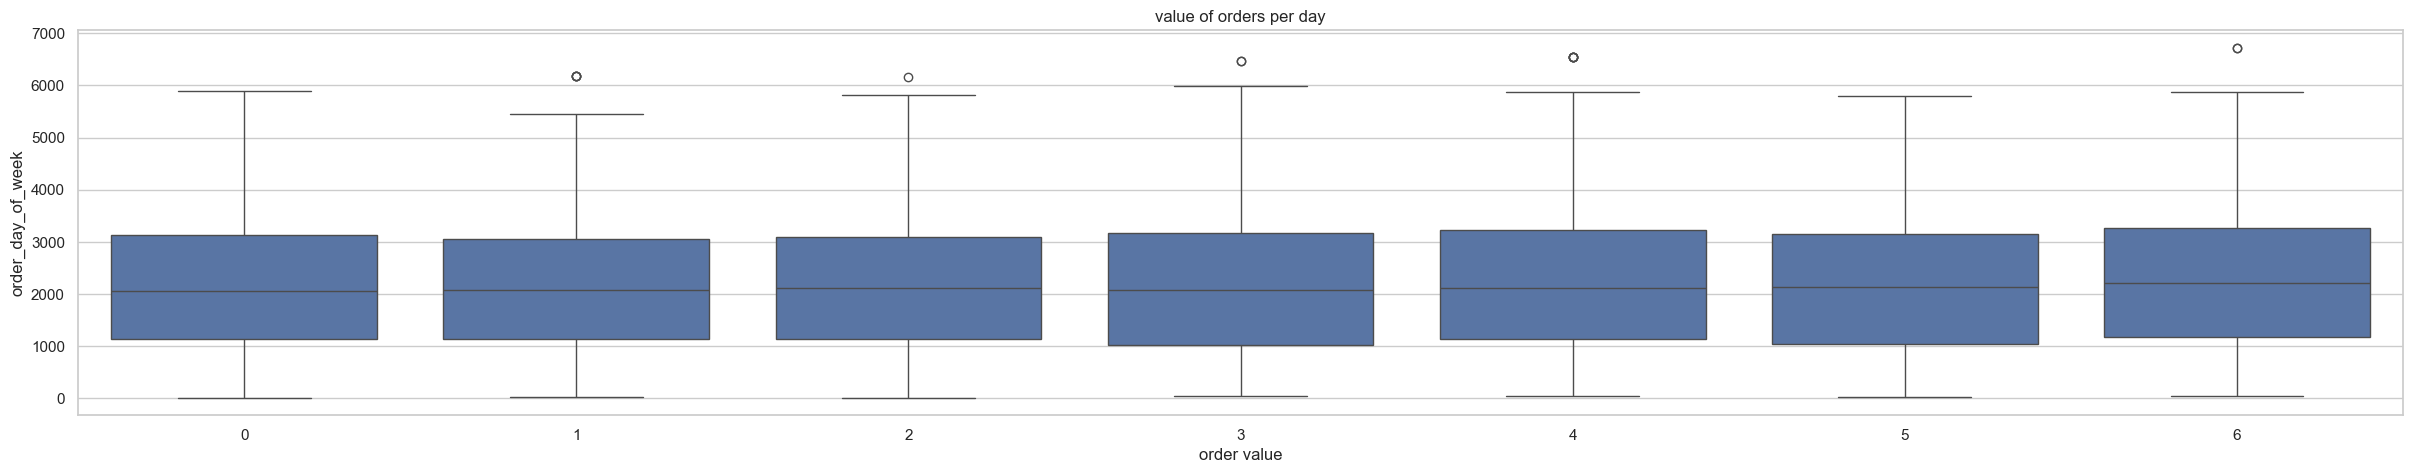

In [204]:
plt.figure(figsize=(30,5))
sns.boxplot(data=sales_forecasting_2, x='order_day_of_week',y="total_sum")
plt.title('value of orders per day')
plt.xlabel('order value')
plt.ylabel('order_day_of_week')
plt.tight_layout
plt.show()

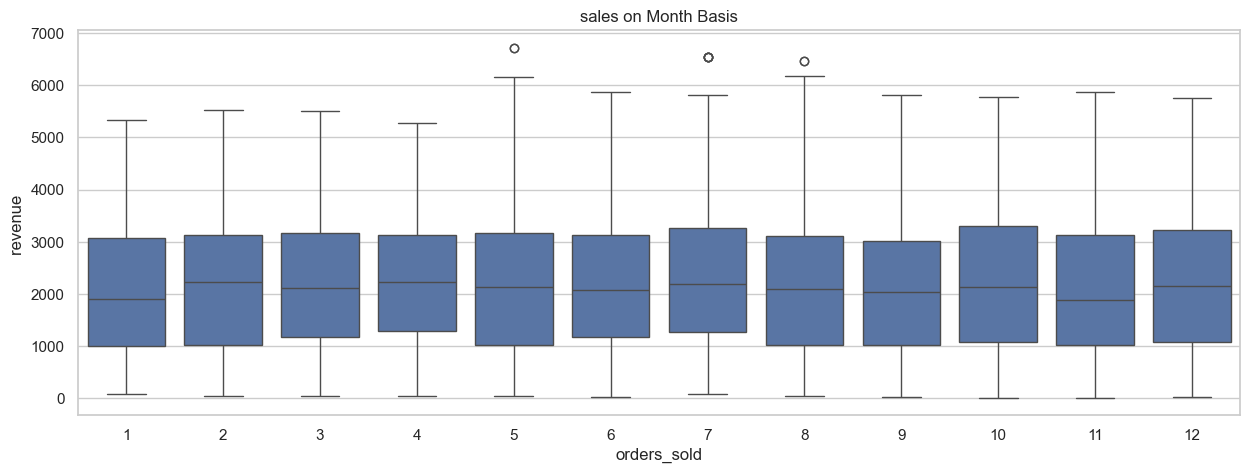

In [206]:
plt.figure(figsize=(15,5))
sns.boxplot(data=sales_forecasting_2, x='order_month',y='total_sum')
plt.title("sales on Month Basis")
plt.ylabel("revenue ")
plt.xlabel('orders_sold')
plt.tight_layout
plt.show()

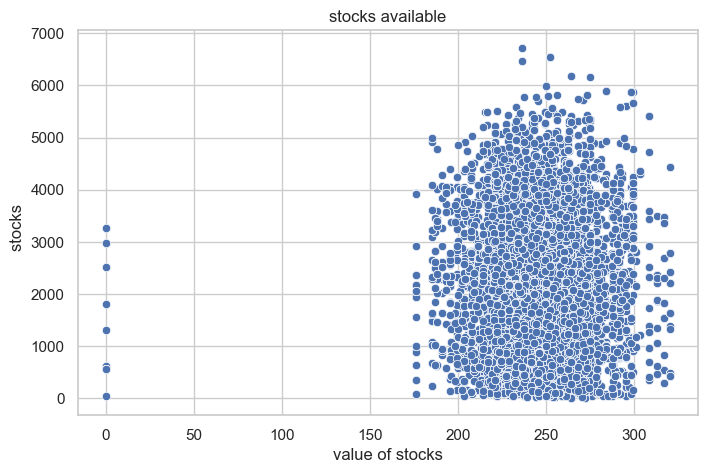

In [210]:
plt.figure(figsize=(8,5))
sns.scatterplot(data= sales_forecasting_2,x='stock_received',y='total_sum')
plt.title("stocks available")
plt.ylabel("stocks  ")
plt.xlabel('value of stocks')
plt.tight_layout
plt.show()

In [212]:
sentiment_mapping ={'negative':0,'neutal': 1, 'positive':2}
sales_forecasting_2.sentiment=sales_forecasting_2.replace(sentiment_mapping,inplace=True)

In [218]:
sales_forecasting_2.sentiment.isna().count()

np.int64(14886)

In [219]:
# predict customer segments with orders
target_encoder=ce.TargetEncoder(cols="customer_segment")
sales_forecasting_2['customer_segment'] = target_encoder.fit_transform(
sales_forecasting_2['customer_segment'], sales_forecasting_2['total_orders'])

In [231]:
sales_forecasting_2['avg_revenue_per_order'] = sales_forecasting_2['total_sum'] / (sales_forecasting_2['total_orders'] + 1e-9)
sales_forecasting_2['avg_revenue_per_stock'] = sales_forecasting_2['total_sum']/(sales_forecasting_2['quantity'] +1e-9)
sales_forecasting_2['Roling_revenue_for_7days'] = sales_forecasting_2['total_sum'].rolling(window=7).std()
sales_forecasting_2['Roling_revenue_for_7days_mean'] = sales_forecasting_2['total_sum'].rolling(window=7).mean()

In [250]:
stats=np.where(sales_forecasting_2['Roling_revenue_for_7days_mean'].isna()==False)

In [251]:
stats

(array([    6,     7,     8, ..., 14883, 14884, 14885], shape=(14880,)),)

In [249]:
sales_forecasting_2['Roling_revenue_for_7days_mean'].isna()

0         True
1         True
2         True
3         True
4         True
         ...  
14881    False
14882    False
14883    False
14884    False
14885    False
Name: Roling_revenue_for_7days_mean, Length: 14886, dtype: bool

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

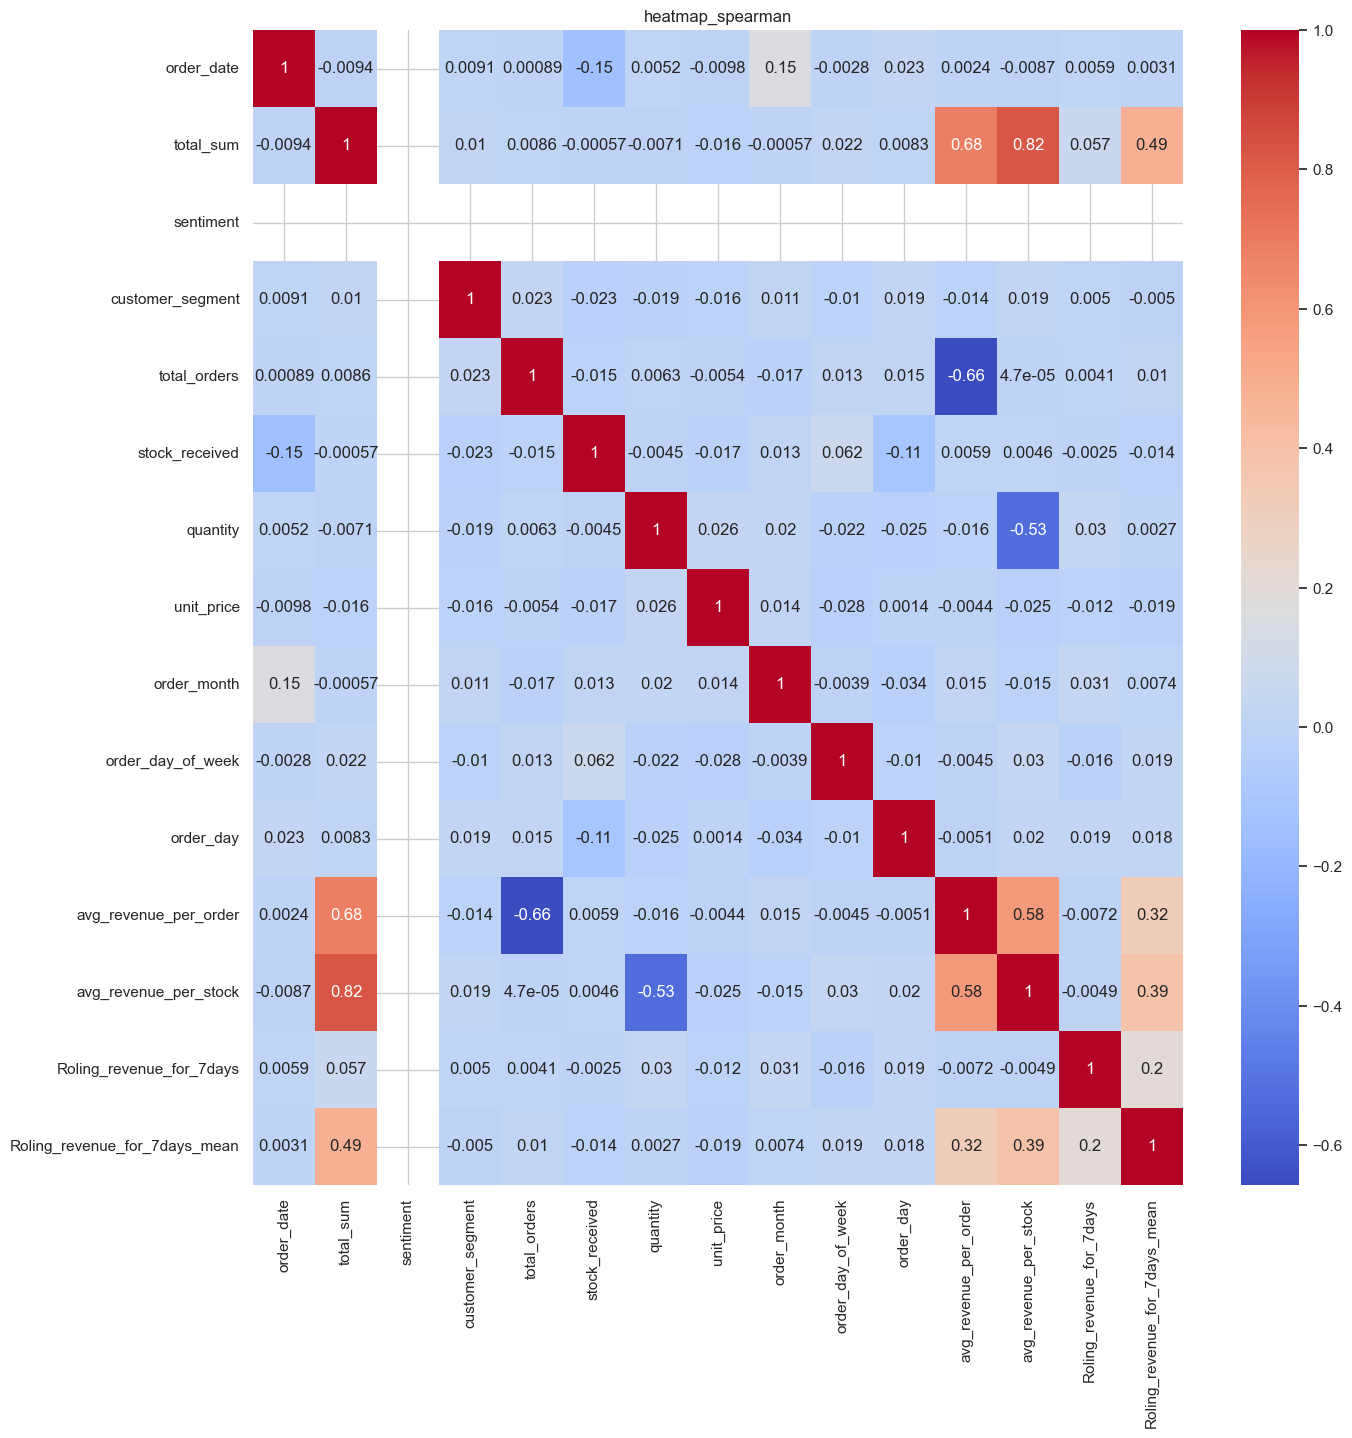

In [259]:
plt.figure(figsize=(15,15))
correlation_table= sales_forecasting_2.corr(method='spearman')
sns.heatmap(correlation_table,annot=True, cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.title('heatmap_spearman')
plt.tight_layout


In [261]:
feature_engineered_cols = [
    'avg_revenue_per_order',
    'avg_revenue_per_stock',
    'Roling_revenue_for_7days',
    'Roling_revenue_for_7days_mean', 
]

# Filtering with the target
eda_df = sales_forecasting_2[feature_engineered_cols + ['total_sum']].copy()


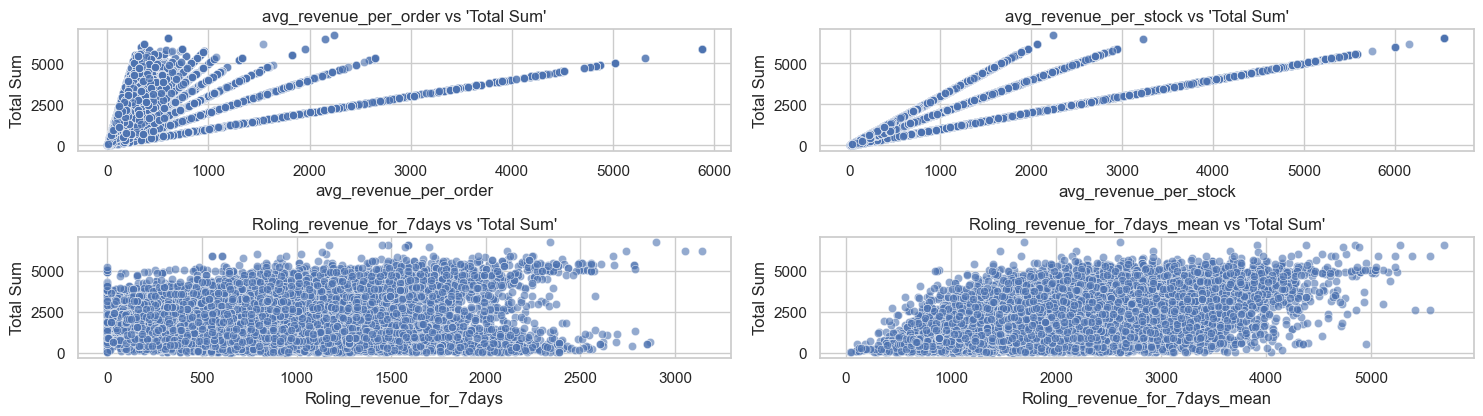

In [270]:
plt.figure(figsize=(15,8))

for i,col in enumerate (feature_engineered_cols):
    plt.subplot(4,2,i+1)
    sns.scatterplot(data=eda_df,x=col, y='total_sum',alpha=0.6)
    plt.title(f"{col} vs 'Total Sum'")
    plt.xlabel(col)
    plt.ylabel("Total Sum")


plt.tight_layout()
plt.show()